# Boilerplate

In [1]:
from fastai.tabular import *
from fastai.text import *
from fastai.vision import Path
import torch.nn.utils.rnn as trnn
import numpy as np
from IPython.core.debugger import set_trace

# Hyperparameters

In [2]:
BATCH_SIZE = 64
TIME_STEP = 5
INPUT_SIZE = 2
HIDDEN_LAYERS = 128
OUTPUT_DIM = 2

# Custom collate_fn to get sequence data

In [3]:
def sequence_collate(batch):
    '''Function that collects `samples` of tabular lines and reshapes them to RNN Sequences of seq_length.'''
    # x.shape -> BSx10 | y.shape -> BS x 1
    x, y = data_collate(batch)    
    #One-Hot encode result(y, True/False) and add it as last sequence
    #oh = one_hot(y, max(y)+1)
 
    # Resize input from BSx10 into paired sequences
    # -> x.shape = (BSx5x2)
    x[1] = x[1].reshape(x[1].size(0), math.ceil(x[1].size(1)/2),-1)
    return [x, y]

## Load Data

In [4]:
gender = 'men'
file = 'normalized_' + gender + '.csv'
path = Path('data')

In [5]:
df = pd.read_csv(path/file)
df.head(3)

,Direction,Tech,Success,Serve_X,Serve_Y,Reception_X,Reception_Y,Set_X,Set_Y,Attack_X,Attack_Y,Inrun_X,Inrun_Y,Defense_X,Defense_Y
0,Line,Shot,True,0.139,0.9756,0.738,0.1478,0.620,0.3644,0.725,0.4244,0.874,0.1550,0.656,0.1633
1,Dia,Smash,False,0.811,1.0000,0.632,0.1983,0.475,0.3694,0.811,0.4417,0.803,0.2106,0.519,0.1900
2,Line,Shot,True,0.798,1.0000,0.401,0.2006,0.604,0.3944,0.548,0.4883,0.485,0.1728,0.352,0.1072


In [6]:
dep_var = 'Success'
cat_names = ['Tech', 'Direction', 'Success']
cont_with_def = ['Serve_X', 'Serve_Y', 'Reception_X', 'Reception_Y', 'Set_X', 'Set_Y', 'Inrun_X', 'Inrun_Y', 'Attack_X', 'Attack_Y', 'Defense_X', 'Defense_Y']
cont_without_def = ['Serve_X', 'Serve_Y', 'Reception_X', 'Reception_Y', 'Set_X', 'Set_Y', 'Inrun_X', 'Inrun_Y', 'Attack_X', 'Attack_Y']
procs = [FillMissing, Categorify]
data_df = df.drop(cat_names, 1)

In [7]:
# Create Databunch
# Split by idx because for some reason the drop_last property in the valid_dl is not respected when using rand_perc
# even if set explicitly.
# This results in an error at validation time, because the last batch has not the right dimensions for the RNN
data = (TabularList.from_df(df, path=path, cont_names=cont_without_def, procs=procs)
                           .split_by_idx(list(range(0,2560)))
                           .label_from_df(cols=dep_var)
                           .databunch(collate_fn=sequence_collate))

data.valid_dl.drop_last = True

In [8]:
# Confirm the size of the last batch that causes the validation error
math.floor(len(df)*0.2) - (math.floor(len(df)*0.2 / 64)*64)

17

## Multi-layer GRU

### Custom Loss and Metrics

In [9]:
def lossOH(input, target):     
    # One-hot encode targets again, since CrossEntropy expects a vector with 1 element per class
    # enc = one_hot(target, max(target)+1)
    r = range(input.size(0))
    # Only take the last hidden layer
    last = torch.stack([input[i][-1] for i in r])
    loss = nn.CrossEntropyLoss()
    return loss(last, target.to(torch.long))


def accSoftLast (input, target):
    r = range(input.size(0))
    # Only take the last hidden layer
    last = torch.stack([input[i][-1] for i in r])
    # Apply softmax
    m = nn.Softmax(dim=1)
    soft = m(last)
    return accuracy(soft, target)

### Model

In [10]:
class beachGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bs, gru_layers):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, gru_layers, batch_first=True)
        self.h_o = nn.Linear(hidden_dim, output_dim)
        self.bn = BatchNorm1dFlat(hidden_dim)
        # Not necessary anymore?
        self.h = torch.zeros(gru_layers, bs, hidden_dim).cuda()
        
    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        res,h = self.gru(x_cont, self.h)
        #res, _ = self.gru(x_cont)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [11]:
learn = Learner(data, beachGRU(INPUT_SIZE, HIDDEN_LAYERS, OUTPUT_DIM, BATCH_SIZE, 1), loss_func=lossOH, metrics=accSoftLast)

### Training

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


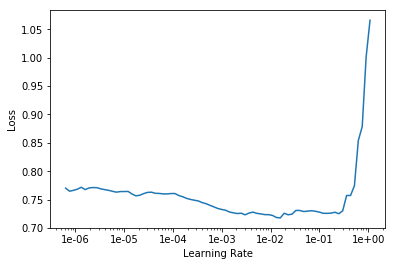

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accSoftLast,time
0,0.710306,0.675260,0.613672,00:02
1,0.705814,3.886986,0.613672,00:02
2,0.667632,3.546297,0.613672,00:02
3,0.664969,1.424135,0.613672,00:02
4,0.664513,0.822294,0.613672,00:02
5,0.657477,0.854186,0.613672,00:02
6,0.658023,0.714560,0.613672,00:02
7,0.661259,0.669052,0.613672,00:02
8,0.664260,0.666192,0.614062,00:02
9,0.657985,0.666008,0.614062,00:02
